# Load data

In [177]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_absolute_error, max_error, explained_variance_score, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from tabulate import tabulate
import matplotlib.pyplot as plt
import shap
# Load the datasets
df = pd.read_csv('enriched_data.csv')

# Check NA values

In [178]:
# Count null values for each column
null_counts = df.isna().sum()
# Print null values in each column
print(null_counts)

Unnamed: 0              0
id                      0
title_x                 0
cast                    0
crew                    0
                       ..
high_value_actors       0
high_value_directors    0
sentiment_label         0
sentiment_score         0
confidence_level        0
Length: 86, dtype: int64


In [179]:
print(df.columns)

Index(['Unnamed: 0', 'id', 'title_x', 'cast', 'crew', 'budget', 'genres',
       'homepage', 'keywords', 'original_language', 'original_title',
       'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title_y', 'vote_average',
       'vote_count', 'genre_science_fiction', 'genre_music', 'genre_tv_movie',
       'genre_romance', 'genre_comedy', 'genre_western', 'genre_fantasy',
       'genre_drama', 'genre_thriller', 'genre_crime', 'genre_history',
       'genre_animation', 'genre_foreign', 'genre_war', 'genre_documentary',
       'genre_horror', 'genre_action', 'genre_adventure', 'genre_mystery',
       'genre_family', 'keyword_woman director', 'keyword_independent film',
       'keyword_duringcreditsstinger', 'keyword_based on novel',
       'keyword_murder', 'keyword_aftercreditsstinger', 'keyword_violence',
       'keyword_dystopia', 'keyword_sport', 'keyword_revenge

# Convert sentiment label
## *Positve = 1 and Negative = 0

In [180]:
df['sentiment_numeric'] = (df['sentiment_label'] == 'POSITIVE').astype(int)

## Log-transform the 'revenue' because it's highly skewed
## Run the model on numerical data
## Split the data 8:2

In [181]:
df['log_adjusted_revenue'] = np.log1p(df['adjusted_revenue'])

features = [
    'runtime', 'popularity', 'genre_science_fiction', 'genre_adventure', 'genre_mystery',
    'genre_action', 'genre_horror', 'genre_fantasy', 'genre_music', 'genre_war', 'genre_comedy',
    'genre_foreign', 'genre_thriller', 'genre_animation', 'genre_crime', 'genre_tv_movie',
    'genre_documentary', 'genre_western', 'genre_family', 'genre_history', 'genre_romance',
    'genre_drama', 'keyword_woman director', 'keyword_independent film', 'keyword_duringcreditsstinger',
    'keyword_based on novel', 'keyword_murder', 'keyword_aftercreditsstinger', 'keyword_violence',
    'keyword_dystopia', 'keyword_sport', 'keyword_revenge', 'adjusted_budget',
    'number_of_cast', 'dominant_topic', 'high_value_actors', 'high_value_directors', 'sentiment_numeric'
]

# Define the target variable
target = 'log_adjusted_revenue'

# Select the features and target
X = df[features]
y = df[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check for Multicollinearity in the data

In [182]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

C:\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


                         feature        VIF
0                        runtime  14.733379
1                     popularity   3.440222
2          genre_science_fiction   1.544888
3                genre_adventure   1.568549
4                  genre_mystery   1.275708
5                   genre_action   2.051324
6                   genre_horror   1.407857
7                  genre_fantasy   1.235422
8                    genre_music   1.101543
9                      genre_war   1.173635
10                  genre_comedy   2.230480
11                 genre_foreign   1.026687
12                genre_thriller   2.314395
13               genre_animation   1.467395
14                   genre_crime   1.741793
15                genre_tv_movie        NaN
16             genre_documentary   1.101937
17                 genre_western   1.055049
18                  genre_family   1.727976
19                 genre_history   1.235416
20                 genre_romance   1.511169
21                   genre_drama

# Linear Regression

In [183]:
# Fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model with additional metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)
rmse = np.sqrt(mse)
normalized_mse = mse / np.var(y_test)
max_err = max_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Display results
print(f"Model Score (%): {r2 * 100:.2f}%")
print(f"R² Score: {r2:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Square Error (RMSE): {rmse:.6f}")
print(f"Normalized MSE: {normalized_mse:.6f}")
print(f"Explained Variance Score (EVS): {evs:.6f}")
print(f"Max Error: {max_err:.6f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Model Score (%): 50.28%
R² Score: 0.502845
Mean Absolute Error (MAE): 0.892349
Mean Squared Error (MSE): 1.435112
Root Mean Square Error (RMSE): 1.197961
Normalized MSE: 0.497155
Explained Variance Score (EVS): 0.504049
Max Error: 6.172441
Mean Absolute Percentage Error (MAPE): 5.64%


# Random Forest

In [184]:
# Fit the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model with additional metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
evs_rf = explained_variance_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
normalized_mse_rf = mse_rf / np.var(y_test)
max_err_rf = max_error(y_test, y_pred_rf)
mape_rf = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100

# Display results
print(f"Model Score (%): {r2_rf * 100:.2f}%")
print(f"R² Score: {r2_rf:.6f}")
print(f"Mean Absolute Error (MAE): {mae_rf:.6f}")
print(f"Mean Squared Error (MSE): {mse_rf:.6f}")
print(f"Root Mean Square Error (RMSE): {rmse_rf:.6f}")
print(f"Normalized MSE: {normalized_mse_rf:.6f}")
print(f"Explained Variance Score (EVS): {evs_rf:.6f}")
print(f"Max Error: {max_err_rf:.6f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_rf:.2f}%")

Model Score (%): 57.76%
R² Score: 0.577632
Mean Absolute Error (MAE): 0.774530
Mean Squared Error (MSE): 1.219230
Root Mean Square Error (RMSE): 1.104187
Normalized MSE: 0.422368
Explained Variance Score (EVS): 0.577932
Max Error: 5.079796
Mean Absolute Percentage Error (MAPE): 4.90%


# Gradient Boosting

In [185]:
# Fit the Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb_model.predict(X_test)

# Evaluate the model with additional metrics
mse_gb = mean_squared_error(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
evs_gb = explained_variance_score(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
normalized_mse_gb = mse_gb / np.var(y_test)
max_err_gb = max_error(y_test, y_pred_gb)
mape_gb = np.mean(np.abs((y_test - y_pred_gb) / y_test)) * 100

# Display results
print(f"Model Score (%): {r2_gb * 100:.2f}%")
print(f"R² Score: {r2_gb:.6f}")
print(f"Mean Absolute Error (MAE): {mae_gb:.6f}")
print(f"Mean Squared Error (MSE): {mse_gb:.6f}")
print(f"Root Mean Square Error (RMSE): {rmse_gb:.6f}")
print(f"Normalized MSE: {normalized_mse_gb:.6f}")
print(f"Explained Variance Score (EVS): {evs_gb:.6f}")
print(f"Max Error: {max_err_gb:.6f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_gb:.2f}%")

Model Score (%): 62.25%
R² Score: 0.622482
Mean Absolute Error (MAE): 0.750376
Mean Squared Error (MSE): 1.089762
Root Mean Square Error (RMSE): 1.043917
Normalized MSE: 0.377518
Explained Variance Score (EVS): 0.622652
Max Error: 4.486191
Mean Absolute Percentage Error (MAPE): 4.73%


# XGBoost

In [186]:
# Fit the XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model with additional metrics
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
evs_xgb = explained_variance_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
normalized_mse_xgb = mse_xgb / np.var(y_test)
max_err_xgb = max_error(y_test, y_pred_xgb)
mape_xgb = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100

# Display results
print(f"Model Score (%): {r2_xgb * 100:.2f}%")
print(f"R² Score: {r2_xgb:.6f}")
print(f"Mean Absolute Error (MAE): {mae_xgb:.6f}")
print(f"Mean Squared Error (MSE): {mse_xgb:.6f}")
print(f"Root Mean Square Error (RMSE): {rmse_xgb:.6f}")
print(f"Normalized MSE: {normalized_mse_xgb:.6f}")
print(f"Explained Variance Score (EVS): {evs_xgb:.6f}")
print(f"Max Error: {max_err_xgb:.6f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_xgb:.2f}%")

Model Score (%): 52.74%
R² Score: 0.527375
Mean Absolute Error (MAE): 0.828862
Mean Squared Error (MSE): 1.364304
Root Mean Square Error (RMSE): 1.168034
Normalized MSE: 0.472625
Explained Variance Score (EVS): 0.527508
Max Error: 5.381898
Mean Absolute Percentage Error (MAPE): 5.23%


In [187]:
# Compile the data into a dictionary
data = {
    "Metric": [
        "Model Score (%)",
        "R² Score",
        "Mean Absolute Error (MAE)",
        "Mean Squared Error (MSE)",
        "Root Mean Square Error (RMSE)",
        "Normalized MSE",
        "Explained Variance Score (EVS)",
        "Max Error",
        "Mean Absolute Percentage Error (MAPE)"
    ],
    "Linear Regression": [
        r2 * 100,  # Model Score (%)
        r2,  # R² Score
        mae,  # MAE
        mse,  # MSE
        rmse,  # RMSE
        normalized_mse,  # Normalized MSE
        evs,  # EVS
        max_err,  # Max Error
        mape  # MAPE
    ],
    "Random Forest": [
        r2_rf * 100,  # Model Score (%)
        r2_rf,  # R² Score
        mae_rf,  # MAE
        mse_rf,  # MSE
        rmse_rf,  # RMSE
        normalized_mse_rf,  # Normalized MSE
        evs_rf,  # EVS
        max_err_rf,  # Max Error
        mape_rf  # MAPE
    ],
    "Gradient Boosting": [
        r2_gb * 100,  # Model Score (%)
        r2_gb,  # R² Score
        mae_gb,  # MAE
        mse_gb,  # MSE
        rmse_gb,  # RMSE
        normalized_mse_gb,  # Normalized MSE
        evs_gb,  # EVS
        max_err_gb,  # Max Error
        mape_gb  # MAPE
    ],
    "XGBoost": [
        r2_xgb * 100,  # Model Score (%)
        r2_xgb,  # R² Score
        mae_xgb,  # MAE
        mse_xgb,  # MSE
        rmse_xgb,  # RMSE
        normalized_mse_xgb,  # Normalized MSE
        evs_xgb,  # EVS
        max_err_xgb,  # Max Error
        mape_xgb  # MAPE
    ]
}

# Create the DataFrame
df_score = pd.DataFrame(data)

print(df_score.to_string(index=False))  

                               Metric  Linear Regression  Random Forest  Gradient Boosting   XGBoost
                      Model Score (%)          50.284537      57.763161          62.248227 52.737469
                             R² Score           0.502845       0.577632           0.622482  0.527375
            Mean Absolute Error (MAE)           0.892349       0.774530           0.750376  0.828862
             Mean Squared Error (MSE)           1.435112       1.219230           1.089762  1.364304
        Root Mean Square Error (RMSE)           1.197961       1.104187           1.043917  1.168034
                       Normalized MSE           0.497155       0.422368           0.377518  0.472625
       Explained Variance Score (EVS)           0.504049       0.577932           0.622652  0.527508
                            Max Error           6.172441       5.079796           4.486191  5.381898
Mean Absolute Percentage Error (MAPE)           5.635498       4.896024           4.734296 

# Predicted revenue
## *The best model was Gradient Boosting so we use that model to predict the revenue

In [188]:
# Make predictions on both train and test sets
y_pred_train = gb_model.predict(X_train) 
y_pred_test = gb_model.predict(X_test)    

# Reverse the log transformation for interpretability
predicted_train_revenue = np.expm1(y_pred_train)  
predicted_test_revenue = np.expm1(y_pred_test)

# Evaluate the model
mse_gb = mean_squared_error(y_test, y_pred_test)
r2_gb = r2_score(y_test, y_pred_test)

print(f"Gradient Boosting - Mean Squared Error: {mse_gb}")
print(f"Gradient Boosting - R² Score: {r2_gb}")

# Add predictions back to the original DataFrame
# Initialize column with NaN
df['predicted_revenue'] = np.nan 
df.loc[X_train.index, 'predicted_revenue'] = predicted_train_revenue  
df.loc[X_test.index, 'predicted_revenue'] = predicted_test_revenue    

# Verify the DataFrame
print(df[['adjusted_revenue', 'log_adjusted_revenue', 'predicted_revenue']].head())

Gradient Boosting - Mean Squared Error: 1.0897617238772304
Gradient Boosting - R² Score: 0.6224822655602902
   adjusted_revenue  log_adjusted_revenue  predicted_revenue
0      7.800100e+07             18.172232       1.762136e+07
1      4.024053e+07             17.510385       5.739019e+07
2      6.652201e+07             18.013044       9.903338e+07
3      1.285167e+08             18.671569       1.422998e+08
4      2.014122e+08             19.120864       1.151913e+08


In [189]:
# Make predictions on both train and test sets
y_pred_train_rf = rf_model.predict(X_train)  
y_pred_test_rf = rf_model.predict(X_test)    

# Reverse the log transformation for interpretability
predicted_train_revenue_rf = np.expm1(y_pred_train_rf)  
predicted_test_revenue_rf = np.expm1(y_pred_test_rf)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_test_rf)
r2_rf = r2_score(y_test, y_pred_test_rf)

print(f"Random Forest - Mean Squared Error: {mse_rf}")
print(f"Random Forest - R² Score: {r2_rf}")

# Add predictions back to the original DataFrame
# Initialize column with NaN
df['predicted_revenue_rf'] = np.nan  
df.loc[X_train.index, 'predicted_revenue_rf'] = predicted_train_revenue_rf  
df.loc[X_test.index, 'predicted_revenue_rf'] = predicted_test_revenue_rf    

# Verify the final DataFrame
print(df[['adjusted_revenue', 'log_adjusted_revenue', 'predicted_revenue_rf']].head())

Random Forest - Mean Squared Error: 1.2192298810300182
Random Forest - R² Score: 0.5776316121564355
   adjusted_revenue  log_adjusted_revenue  predicted_revenue_rf
0      7.800100e+07             18.172232          4.395312e+07
1      4.024053e+07             17.510385          4.272699e+07
2      6.652201e+07             18.013044          8.054399e+07
3      1.285167e+08             18.671569          1.339355e+08
4      2.014122e+08             19.120864          1.633056e+08


In [190]:
features_withoutNLP = [
    'runtime', 'popularity', 'genre_science_fiction', 'genre_adventure', 'genre_mystery',
    'genre_action', 'genre_horror', 'genre_fantasy', 'genre_music', 'genre_war', 'genre_comedy',
    'genre_foreign', 'genre_thriller', 'genre_animation', 'genre_crime', 'genre_tv_movie',
    'genre_documentary', 'genre_western', 'genre_family', 'genre_history', 'genre_romance',
    'genre_drama', 'keyword_woman director', 'keyword_independent film', 'keyword_duringcreditsstinger',
    'keyword_based on novel', 'keyword_murder', 'keyword_aftercreditsstinger', 'keyword_violence',
    'keyword_dystopia', 'keyword_sport', 'keyword_revenge', 'adjusted_budget',
    'number_of_cast'
]

# Define the target variable
target = 'log_adjusted_revenue'

# Select the features and target
X = df[features_withoutNLP]
y = df[target]

# Split the data into training and test sets
X_train_withoutNLP, X_test_withoutNLP, y_train_withoutNLP, y_test_withoutNLP = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_withoutNLP, y_train_withoutNLP)
# Make predictions on both train and test sets
y_pred_train_rf = rf_model.predict(X_train_withoutNLP) 
y_pred_test_rf = rf_model.predict(X_test_withoutNLP)  

# Reverse the log transformation for interpretability
predicted_train_revenue_rf = np.expm1(y_pred_train_rf) 
predicted_test_revenue_rf = np.expm1(y_pred_test_rf)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_test_rf)
r2_rf = r2_score(y_test, y_pred_test_rf)

print(f"Random Forest - Mean Squared Error: {mse_rf}")
print(f"Random Forest - R² Score: {r2_rf}")

# Add predictions back to the original DataFrame
# Initialize column with NaN
df['predicted_revenue_rf_withoutNLP'] = np.nan 
df.loc[X_train.index, 'predicted_revenue_rf_withoutNLP'] = predicted_train_revenue_rf
df.loc[X_test.index, 'predicted_revenue_rf_withoutNLP'] = predicted_test_revenue_rf   

# Verify the final DataFrame
print(df[['adjusted_revenue', 'log_adjusted_revenue', 'predicted_revenue_rf_withoutNLP']].head())

Random Forest - Mean Squared Error: 1.2579836854146313
Random Forest - R² Score: 0.5642064311176427
   adjusted_revenue  log_adjusted_revenue  predicted_revenue_rf_withoutNLP
0      7.800100e+07             18.172232                     3.685127e+07
1      4.024053e+07             17.510385                     4.316153e+07
2      6.652201e+07             18.013044                     8.042498e+07
3      1.285167e+08             18.671569                     1.326914e+08
4      2.014122e+08             19.120864                     1.615704e+08


# Predicted ROI
## *Use the predicted revenue from the best model (gradient boosting) to calculate predicted ROI (involved NLP features)

In [191]:
# Calculate predicted ROI for the best model
df['predicted_ROI'] = ((df['predicted_revenue'] - df['adjusted_budget']) / df['adjusted_budget']) * 100

# Verify the DataFrame with ROI
print(df[['adjusted_budget', 'adjusted_revenue', 'predicted_revenue', 'predicted_ROI']].head())

# Summary statistics for predicted_ROI from the best model
print("Predicted ROI statistics:")
print(df['predicted_ROI'].describe())

   adjusted_budget  adjusted_revenue  predicted_revenue  predicted_ROI
0       15195000.0      7.800100e+07       1.762136e+07      15.968126
1      154800000.0      4.024053e+07       5.739019e+07     -62.926234
2      153768000.0      6.652201e+07       9.903338e+07     -35.595587
3      150150000.0      1.285167e+08       1.422998e+08      -5.228235
4       72030000.0      2.014122e+08       1.151913e+08      59.921251
Predicted ROI statistics:
count    2180.000000
mean       60.296562
std       102.551619
min       -99.088214
25%       -15.270992
50%        43.110936
75%       112.949207
max      1097.032721
Name: predicted_ROI, dtype: float64


## *Use the predicted revenue from the second best model (random forest) to calculate predicted ROI (involved NLP features)

In [192]:
# Calculate predicted ROI for random forest model 
df['predicted_ROI_rf'] = ((df['predicted_revenue_rf'] - df['adjusted_budget']) / df['adjusted_budget']) * 100

# Verify the DataFrame with ROI
print(df[['adjusted_budget', 'adjusted_revenue', 'predicted_revenue_rf', 'predicted_ROI_rf']].head())

# Summary statistics for predicted_ROI
print("Predicted ROI statistics:")
print(df['predicted_ROI'].describe())

   adjusted_budget  adjusted_revenue  predicted_revenue_rf  predicted_ROI_rf
0       15195000.0      7.800100e+07          4.395312e+07        189.260445
1      154800000.0      4.024053e+07          4.272699e+07        -72.398586
2      153768000.0      6.652201e+07          8.054399e+07        -47.619797
3      150150000.0      1.285167e+08          1.339355e+08        -10.798835
4       72030000.0      2.014122e+08          1.633056e+08        126.718849
Predicted ROI statistics:
count    2180.000000
mean       60.296562
std       102.551619
min       -99.088214
25%       -15.270992
50%        43.110936
75%       112.949207
max      1097.032721
Name: predicted_ROI, dtype: float64


## *Use the predicted revenue from the second best model (random forest) to calculate predicted ROI (without NLP features)

In [193]:
# Calculate predicted ROI for random forest model
df['predicted_ROI_rf_withoutNLP'] = ((df['predicted_revenue_rf_withoutNLP'] - df['adjusted_budget']) / df['adjusted_budget']) * 100

# Verify the DataFrame with ROI
print(df[['adjusted_budget', 'adjusted_revenue', 'predicted_revenue_rf_withoutNLP', 'predicted_ROI_rf_withoutNLP']].head())

# Summary statistics for predicted_ROI
print("Predicted ROI statistics:")
print(df['predicted_ROI'].describe())

   adjusted_budget  adjusted_revenue  predicted_revenue_rf_withoutNLP  \
0       15195000.0      7.800100e+07                     3.685127e+07   
1      154800000.0      4.024053e+07                     4.316153e+07   
2      153768000.0      6.652201e+07                     8.042498e+07   
3      150150000.0      1.285167e+08                     1.326914e+08   
4       72030000.0      2.014122e+08                     1.615704e+08   

   predicted_ROI_rf_withoutNLP  
0                   142.522328  
1                   -72.117875  
2                   -47.697192  
3                   -11.627421  
4                   124.309817  
Predicted ROI statistics:
count    2180.000000
mean       60.296562
std       102.551619
min       -99.088214
25%       -15.270992
50%        43.110936
75%       112.949207
max      1097.032721
Name: predicted_ROI, dtype: float64


# Extract the data with prediction

In [194]:
df.to_csv('revenue_prediction.csv', index=False)

# Find the important variables in the model

Top 10 Most Important Features:
                   Feature  Importance
32         adjusted_budget    0.572377
1               popularity    0.311693
0                  runtime    0.020950
33          number_of_cast    0.014309
34          dominant_topic    0.012748
22  keyword_woman director    0.007527
6             genre_horror    0.006012
2    genre_science_fiction    0.005906
26          keyword_murder    0.004166
17           genre_western    0.004157


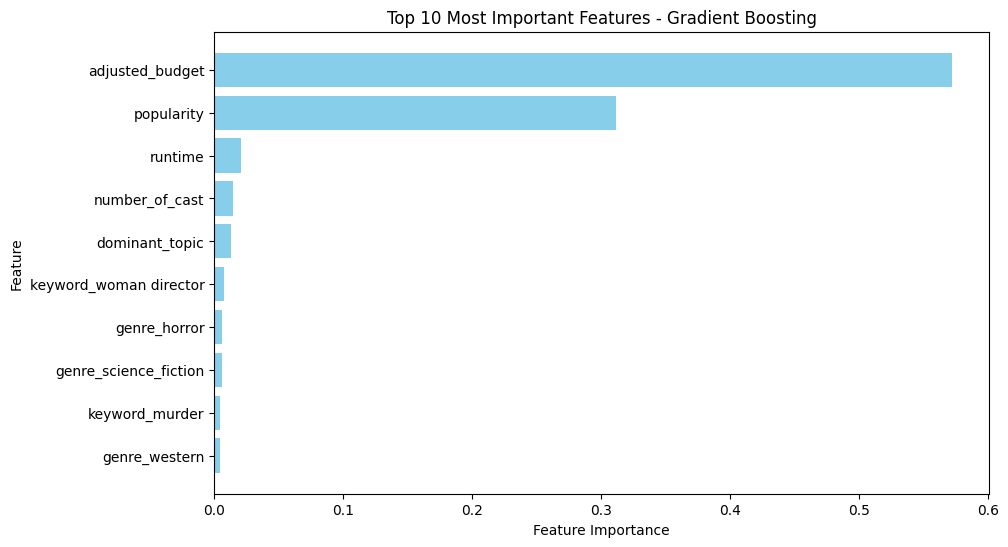

In [195]:
# Get feature importance scores from the Gradient Boosting model
feature_importances = gb_model.feature_importances_

# Create a DataFrame to organize feature importances
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
print("Top 10 Most Important Features:")
print(importance_df.head(10))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10][::-1], importance_df['Importance'][:10][::-1], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 10 Most Important Features - Gradient Boosting")
plt.show()

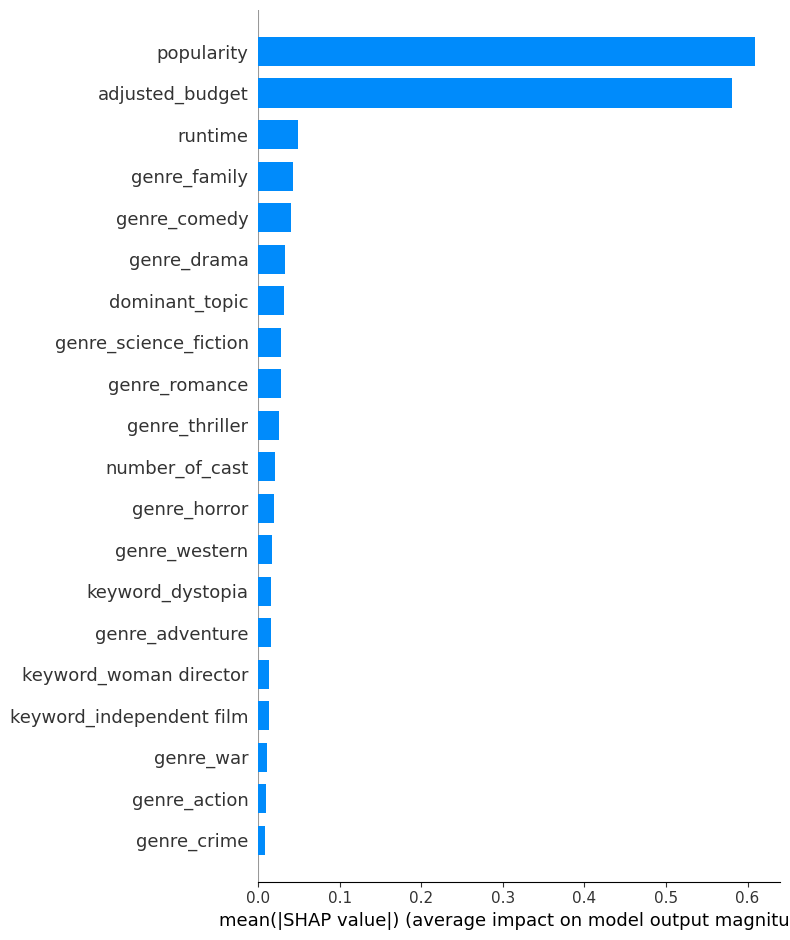

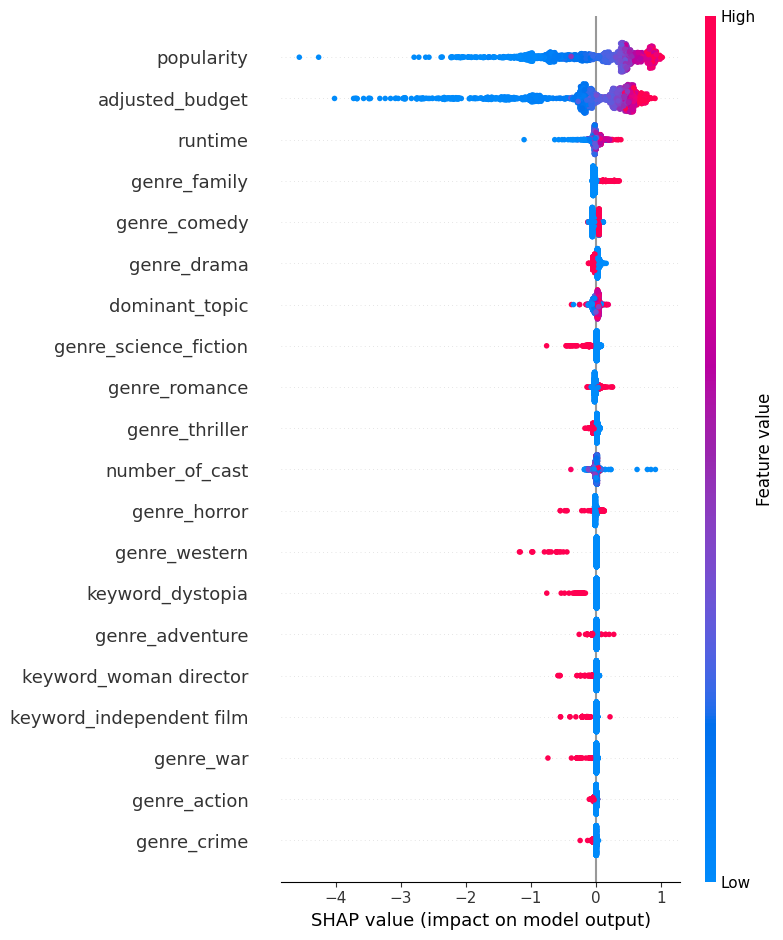

In [196]:
# Initialize the SHAP explainer
explainer = shap.Explainer(gb_model, X_train)

# Calculate SHAP values for the training set
shap_values = explainer(X_train)

# Summary plot to show impact (positive/negative) of each feature
shap.summary_plot(shap_values, X_train, plot_type="bar")  
shap.summary_plot(shap_values, X_train)